In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

### <font size="7">Merkmalsrelevanz</font><a class="anchor" id="4-03f-relevanz"></a>

<font size="5">
Es wird untersucht, wie entscheidend die einzelnen Merkmale für die Vorhersagen im Netz sind. Dafür wird das trainierte Modell getestet. Beim Test wird jeweils ein Merkmal in den Testdaten zufällig durchmischt. Wenn sich die Vorhersagen durch die zufällige Durchmischung stark verändern, dann ist das Merkmal besonders wichtig für das Modell. Wenn sich die Vorhersagen umgekehrt kaum oder gar nicht ändern, ist das Merkmal für das Modell irrelevant.
</font>


In [2]:
from tensorflow.keras.models import load_model
model = load_model("Modelle/LSTM.h5", custom_objects={"root_mean_squared_error":root_mean_squared_error})
model.summary()

window_size = 14

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 14, 64)            320       
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99,265
Trainable params: 99,265
Non-trainable params: 0
_________________________________________________________________


## <font size="6">Verbrauch</font><a class="anchor" id="4-03f-verbrauch"></a>

<font size="5">
Wenn der Verbrauch durchmischt wird, fällt der MAPE sehr stark auf 12,6% auf den Test- und 12,55% auf den Trainingsdaten. Die Vorhersagen sind sehr ungenau und weichen stark von den tatsächlichen Vorhersagen ab. Der Verbrauch ist also wichtig für das Modell.
</font>


In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_train_true = df_unscaled["verbrauch"]["2015-01-15":"2020-12-31"]
y_test_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Verbrauch bei Testdaten durchmischen
df_scaled["verbrauch"][:] = df_scaled["verbrauch"][:].reindex(np.random.permutation(df_scaled["verbrauch"][:].index))

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

        Testdaten Trainingsdaten
R2          -0.29           0.01
MAE       22961.0        20887.0
MSE   895013172.0    718064226.0
RMSE      29917.0        26797.0
                                
MAPE      12.58 %        12.55 %


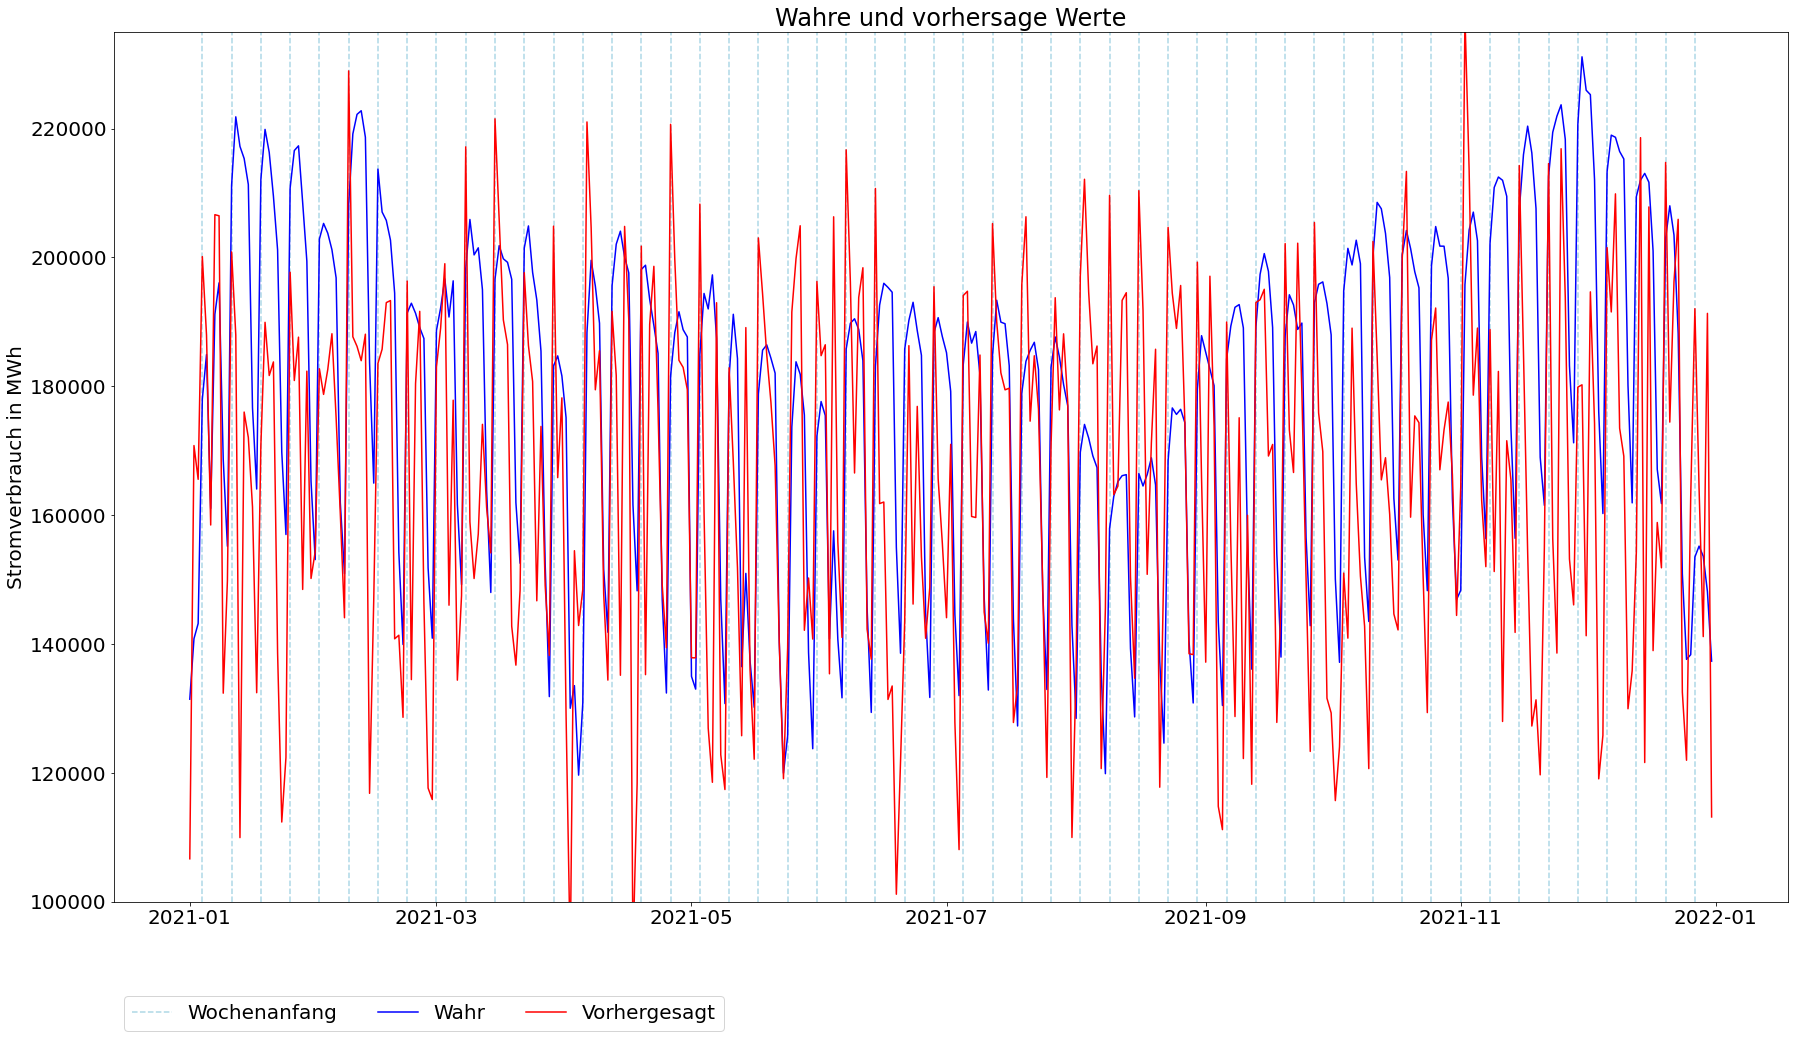

In [4]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train, plot=True)

## <font size="6">Arbeitstag</font><a class="anchor" id="4-03f-arbeitstag"></a>

<font size="5">
Wenn der Indikator für Arbeitstage durchmischt wird, fällt der MAPE sogar noch stärk auf 13,74% auf den Test- und 16,11% auf den Trainingsdaten. Die Vorhersagen weichen sehr stark von den tatsächlichen Vorhersagen ab. Der Indikator für Arbeitstage ist also ebenfalls entscheidend für das Modell.
</font>


In [5]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_train_true = df_unscaled["verbrauch"]["2015-01-15":"2020-12-31"]
y_test_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Verbrauch bei Testdaten durchmischen
df_scaled["arbeitstag"][:] = df_scaled["arbeitstag"][:].reindex(np.random.permutation(df_scaled["arbeitstag"][:].index))

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

        Testdaten Trainingsdaten
R2          -0.38          -0.47
MAE       24040.0        25892.0
MSE   960900979.0   1065403648.0
RMSE      30998.0        32641.0
                                
MAPE      13.74 %        16.11 %


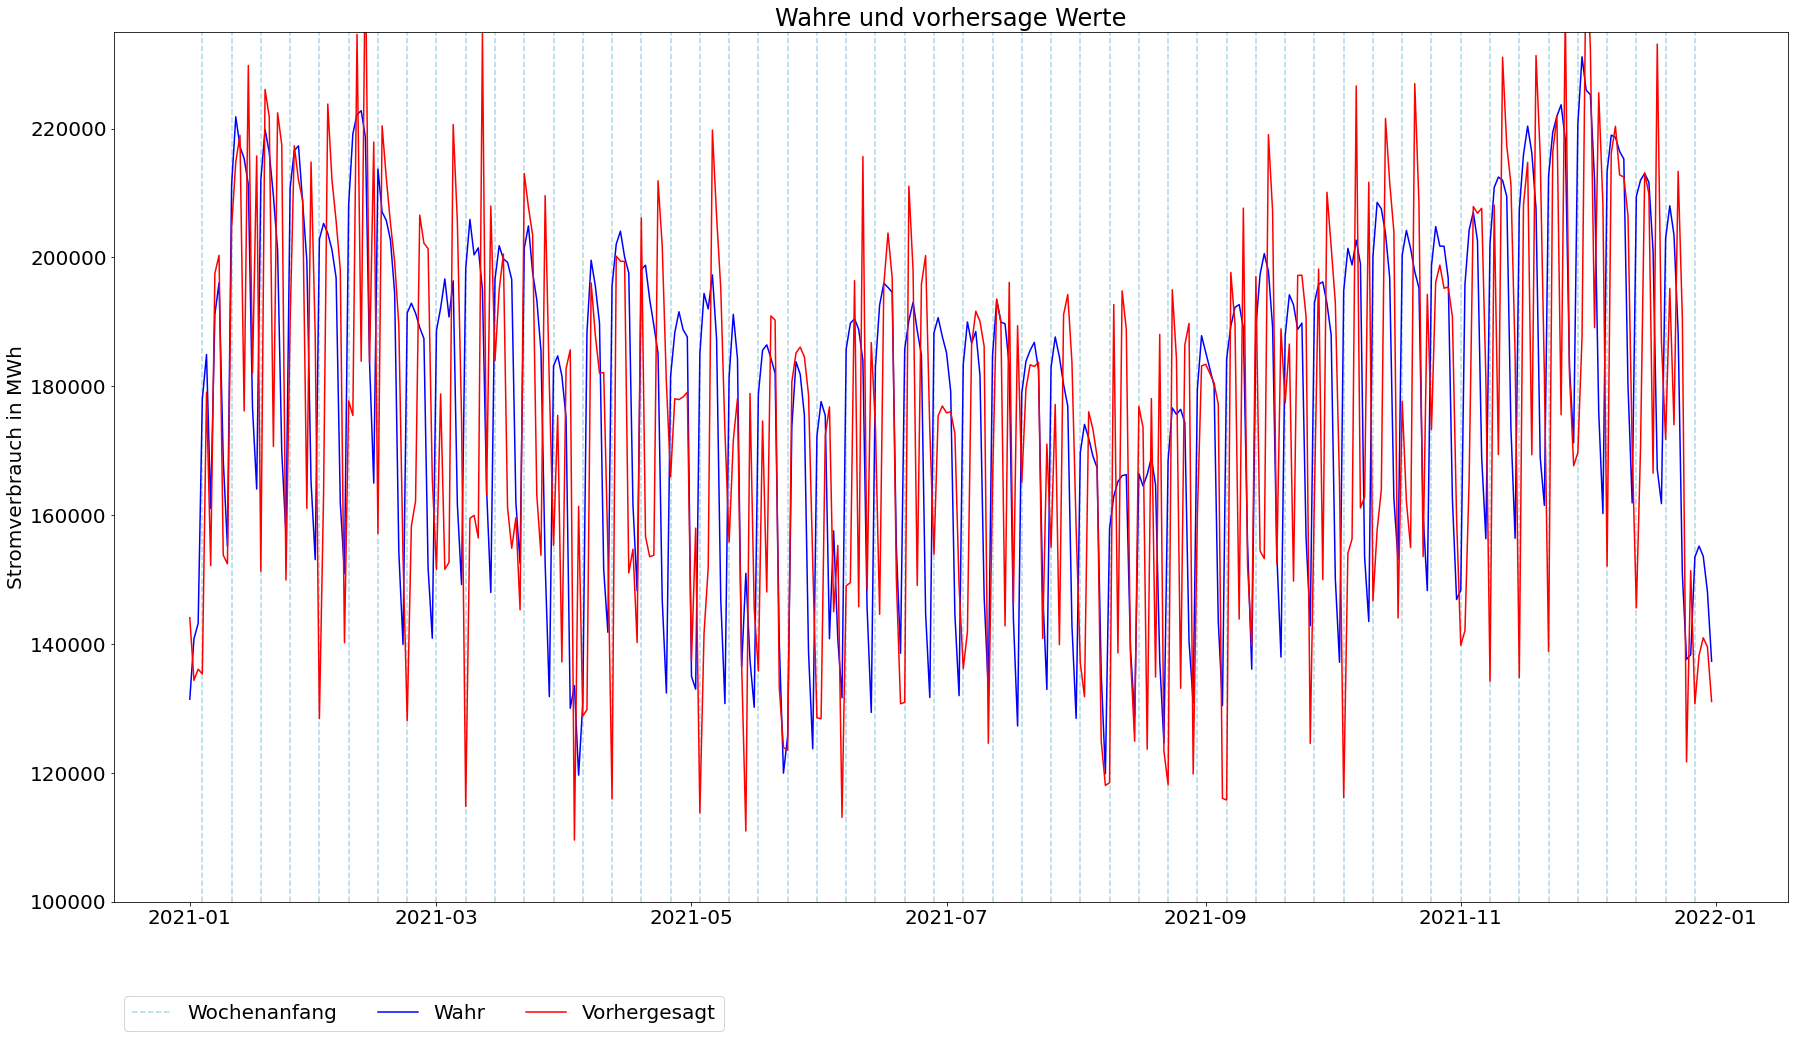

In [6]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train, plot=True)

## <font size="6">Temperatur</font><a class="anchor" id="4-03f-temperatur"></a>

<font size="5">
Wenn die Temperatur durchmischt wird, fällt der MAPE wesentlich weniger stark auf 2,8% auf den Test- und 2,37% auf den Trainingsdaten. Die Vorhersagen weichen also nicht so stark ab wie beim Durchmischen des Verbrauchs oder der Arbeitstage. Allerdings entspricht eine Steigerung des MAPE um 0,8 Prozentpunkte immerhin einer Verschlechterung um 40%. Das Modell ist also in der Lage, einen gewissen Informationsgehalt aus den Daten zu generalisieren.
</font>


In [61]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_train_true = df_unscaled["verbrauch"]["2015-01-15":"2020-12-31"]
y_test_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Verbrauch bei Testdaten durchmischen
df_scaled["temperatur"][:] = df_scaled["temperatur"][:].reindex(np.random.permutation(df_scaled["temperatur"][:].index))

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

       Testdaten Trainingsdaten
R2          0.95           0.96
MAE       4834.0         3859.0
MSE   37353801.0     25730701.0
RMSE      6112.0         5073.0
                               
MAPE       2.8 %         2.37 %


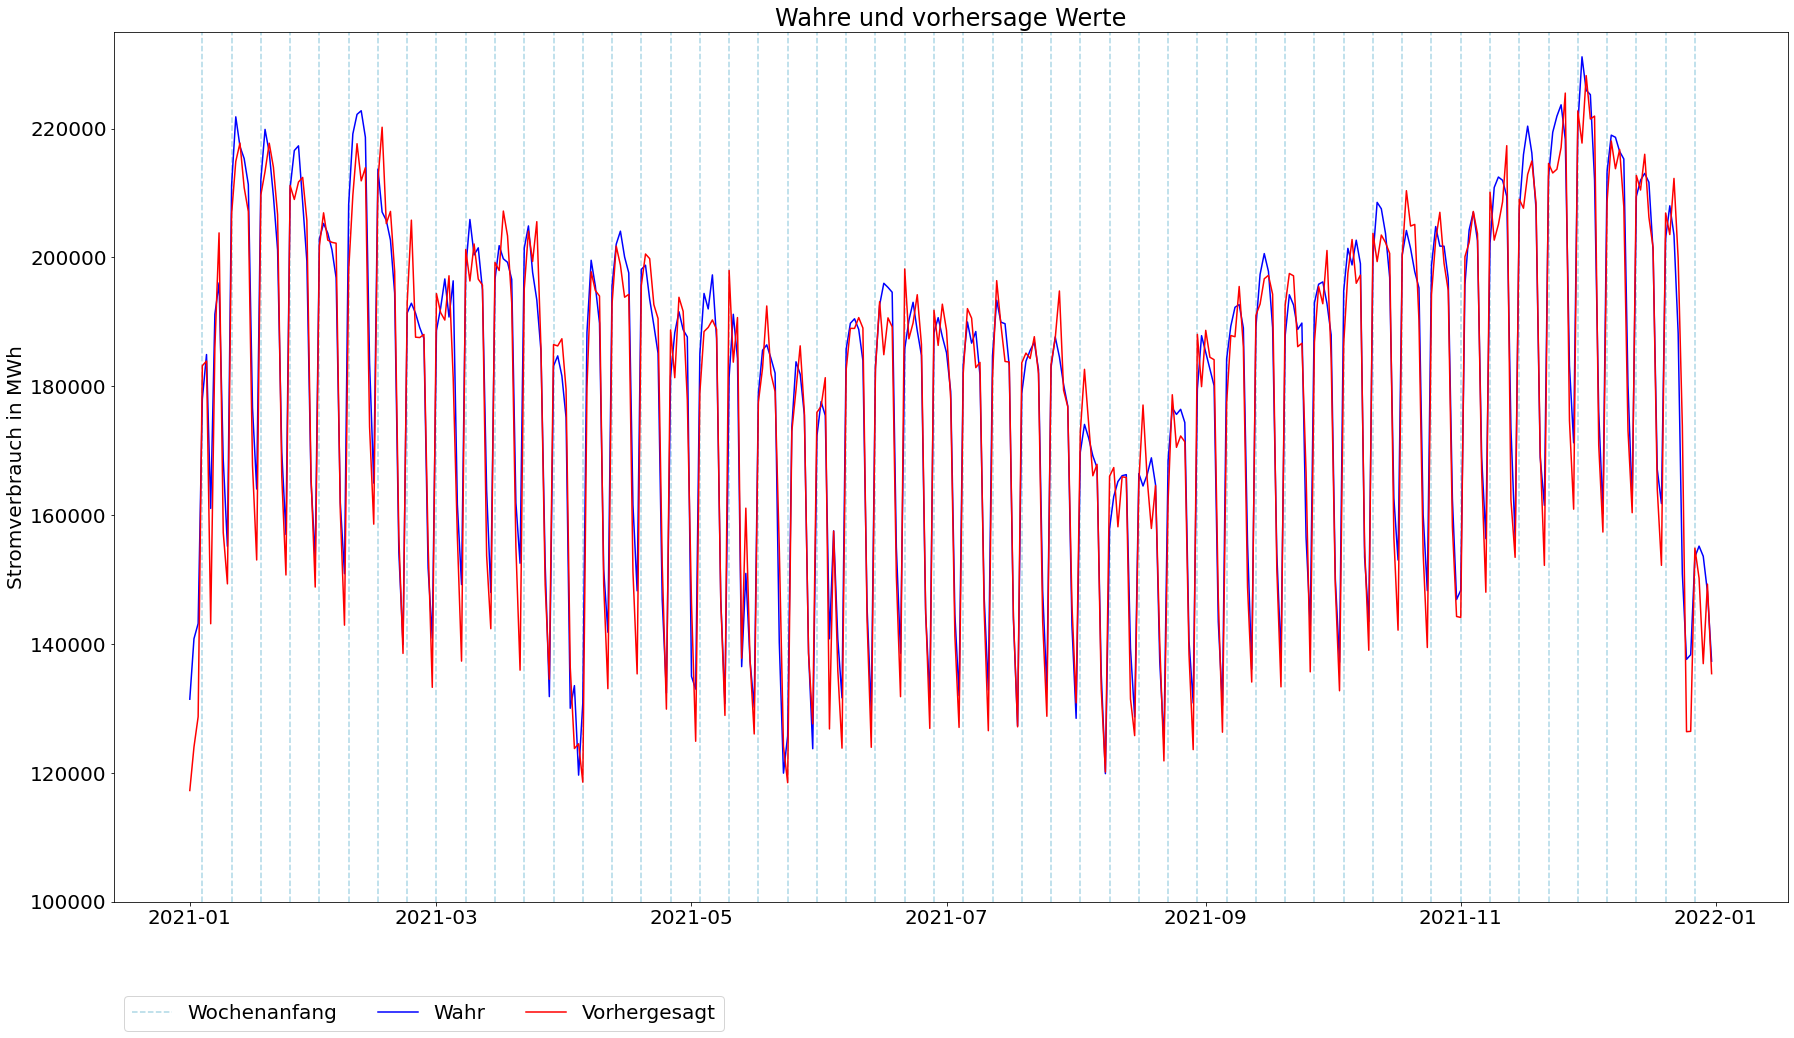

In [30]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train, plot=True)

## <font size="6">Tagesstunden</font><a class="anchor" id="4-03f-temperatur"></a>

<font size="5">
Wenn die Tagesstunden durchmischt werden, fällt der MAPE ähnlich stark auf 3,1% auf den Test- und 2,28% auf den Trainingsdaten. Die Vorhersagen weichen also nicht so stark ab wie beim Durchmischen des Verbrauchs oder der Arbeitstage, allerdings ähnlich wie bei der Temperatur. Auch hier gilt, eine Steigerung des MAPE auf 3,1% entspricht einer Verschlechterung um 50% Das Modell ist also in der Lage, einen gewissen Informationsgehalt aus den Daten zu generalisieren. Die Vorhersagen verschlechtern sich vor Allem Anfang und Ende des Jahres, wenn die Tagesstunden besonders niedrige Werte annehmen. 
</font>


In [56]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_train_true = df_unscaled["verbrauch"]["2015-01-15":"2020-12-31"]
y_test_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Verbrauch bei Testdaten durchmischen
df_scaled["tagesstunden"][:] = df_scaled["tagesstunden"][:].reindex(np.random.permutation(df_scaled["tagesstunden"][:].index))

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

       Testdaten Trainingsdaten
R2          0.93           0.93
MAE       5330.0         5165.0
MSE   51337345.0     51545642.0
RMSE      7165.0         7180.0
                               
MAPE       3.1 %         3.28 %


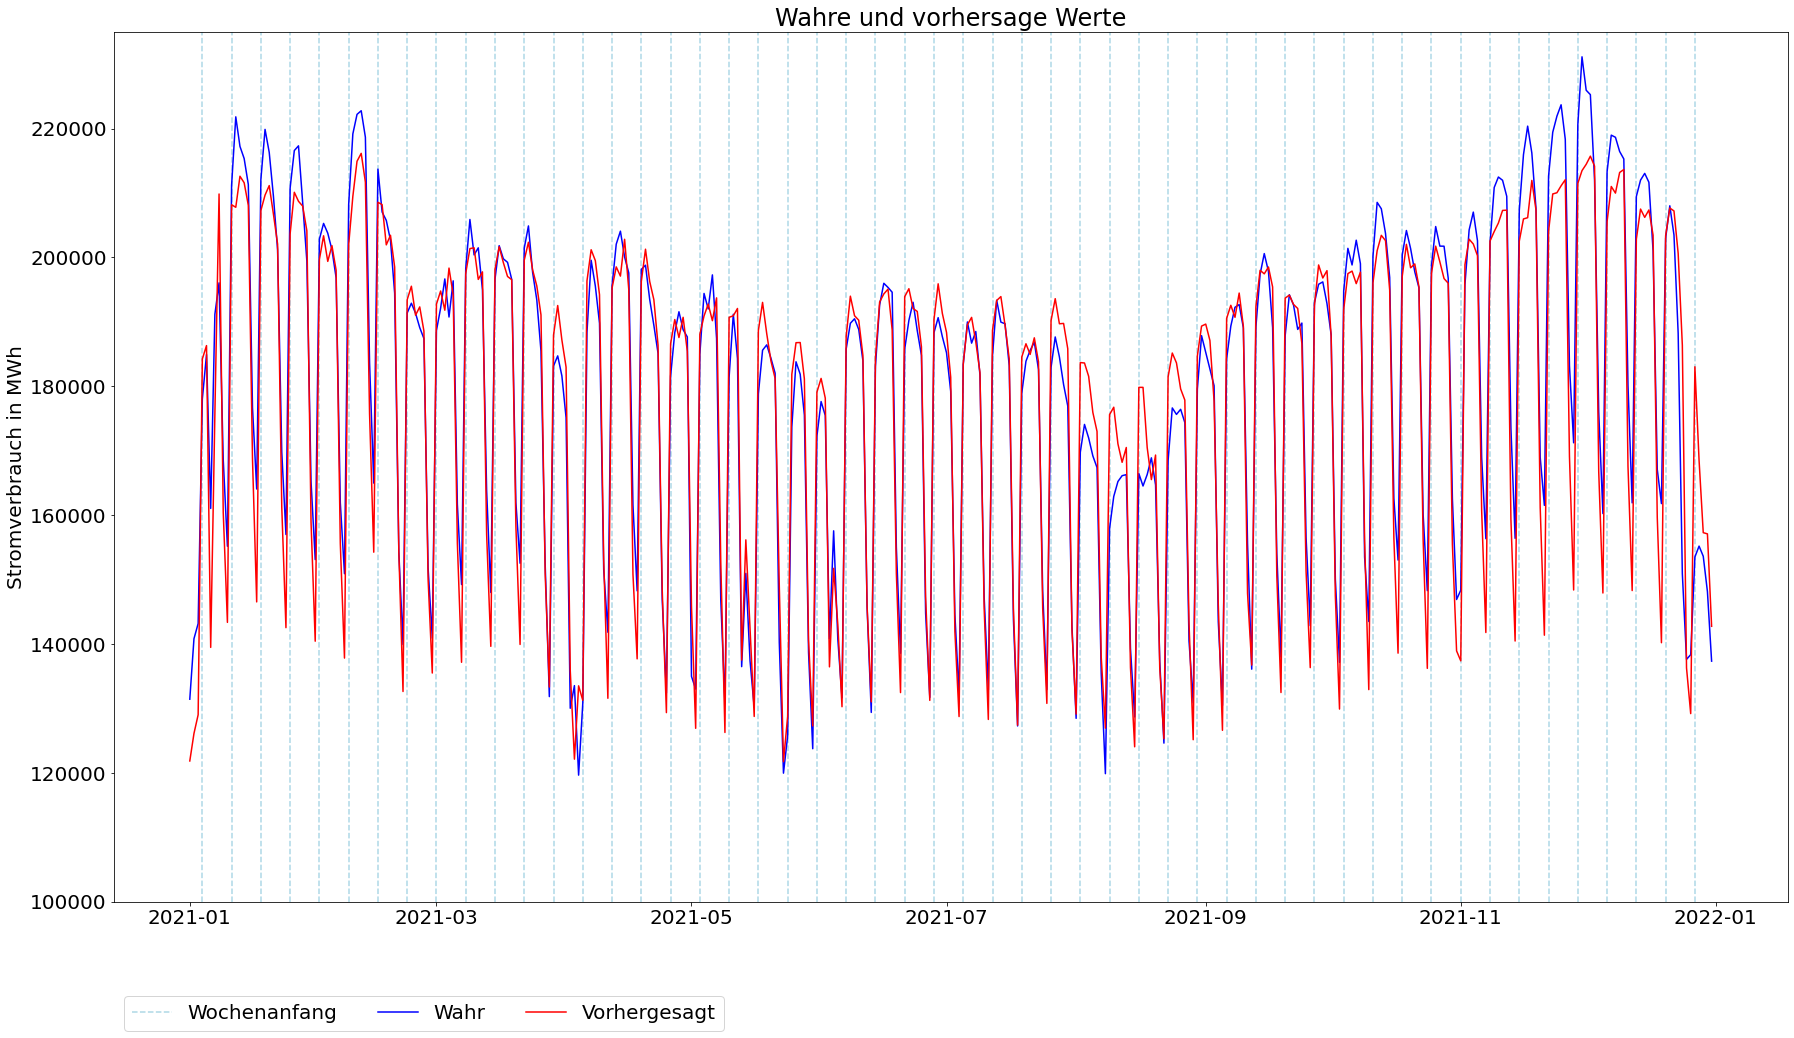

In [55]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train, plot=True)